#**Description**
Goal is to predict the patient's head side in the depth images. We employ CNN-based approach for it. 

In [1]:
# Mount the drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
# Change current working directory
import os
os.chdir('/content/gdrive/MyDrive/Projects/head_location')

In [3]:
# Add folder with .py files to system path
import sys
sys.path.append('/contect/gdrive/MyDrive/Projects/head_location/scripts')

##**Import modules**

In [4]:
import os
import cv2
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import confusion_matrix

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

from matplotlib import pyplot as plt
from scripts import dataloader
from scripts.dataloader import *

TRAIN_DIR = './dataset/train/'
TEST_DIR = './dataset/test/'

# Check hardware accelerator
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
cpu


In [5]:
### Exploring Dataset

classes = os.listdir(TRAIN_DIR)
print("Total Classes: ",len(classes))

#Counting total train, & test images

train_count = 0
test_count = 0

for _class in classes:
    train_count += len(os.listdir(TRAIN_DIR + _class))
    test_count += len(os.listdir(TEST_DIR + _class))

print("Total train images: ",train_count)
print("Total test images: ",test_count)

Total Classes:  2
Total train images:  1650
Total test images:  26


In [6]:
# Utility to apply transforms
def get_transform():
  mean = (0.5)
  std = (0.5)
  normalize = T.Normalize(mean=mean, std=std)
  return T.Compose([normalize])

##**Loading Classification Dataset**

In [7]:
train_dataset = CustomDataset(TRAIN_DIR)
test_dataset = CustomDataset(TEST_DIR)

print(len(train_dataset))
print(len(test_dataset))

1650
26


Amount of data is very small. Data from only three patients is used for testing purpose. Training data is increase from only around 75 images to 1650 images via augmentation.

Data is separated for testing on subject-level and not image-level to have unbiased evaluation of the model.

In [8]:
train_data_loader = DataLoader(dataset = train_dataset, batch_size = 16, shuffle=True)
test_data_loader = DataLoader(dataset = test_dataset, batch_size = 16, shuffle=False)

In [9]:
print(len(train_data_loader))

104


In [10]:
# for i, (images, labels) in enumerate(train_data_loader):
#   print(labels.shape)
#   break

In [11]:
for i, (images, labels) in enumerate(train_data_loader):
  print(images.shape)
  break

torch.Size([16, 3, 240, 320])


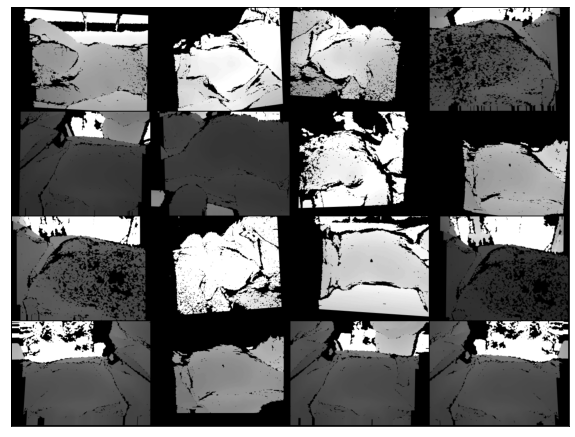

In [23]:
# Visualize one training batch
for images, labels in train_data_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4, normalize=True).permute(1,2,0), cmap='gray')
    break

In [ ]:
def set_device():
  if torch.cuda.is_available():
    dev = "cuda:0"
  else:
    dev = "cpu"
  return torch.device(dev)

##**Define Training Loop**

In [ ]:
# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs):
  device = set_device()
  train_loss = []
  train_acc = []

  for epoch in range(num_epochs):
    print("Epoch number {}".format(epoch + 1))
    start = time.time()
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
      
    # Training
    for data in train_data_loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      total += labels.size(0)
      
      #Reset Grads
      optimizer.zero_grad()
      
      #Forward ->
      outputs = model(images)

      # pred
      _, predicted = torch.max(outputs.data, 1)

      
      #Calculate Loss & Backward, Update Weights (Step)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item() 
      running_correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_data_loader)
    epoch_acc = 100.00 * running_correct / total

    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

    print("  - Training dataset: Got %d out of %d images correctly (%.3f%%). \nEpoch loss: %.3f"
        % (running_correct, total, epoch_acc, epoch_loss))

    test_acc = evaluate_model(model, test_loader)
      
    end = time.time()

    print("-  Epoch Time : {} \n".format(int(end-start)))

  print('Finished')
  return model, train_acc, train_loss, test_acc

In [ ]:
# Testing function
def evaluate_model(model, test_loader):
  model.eval()
  predicted_correctly_on_epoch = 0
  total = 0
  best_acc = 0.0
  acc = []
  device = set_device()

  with torch.no_grad():
    for data in test_data_loader: 
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      total += labels.size(0)

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)

      predicted_correctly_on_epoch += (predicted == labels).sum().item()
  
  epoch_acc = 100.0 * predicted_correctly_on_epoch / total
  acc.append(epoch_acc)

  if epoch_acc > best_acc:
    best_acc = epoch_acc
    torch.save(model.state_dict(), './model/best_model2.pth')

  print("  - Testing dataset: Got %d out of %d images correctly (%.3f%%)"
        % (predicted_correctly_on_epoch, total, epoch_acc))
  
  return acc

##**Define the model**

In [26]:
resnet18_model = models.resnet18(pretrained=False)
num_features = resnet18_model.fc.in_features
num_classes = 2
resnet18_model.fc = nn.Linear(num_features, num_classes)
print(resnet18_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

##**Define Hyperparameters**

In [30]:
model = resnet18_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
EPOCHS = 50

##**Training phase**

In [ ]:
model_trained, TRAIN_LOSS, TRAIN_ACC, TEST_ACC = train_model(model, train_data_loader, test_data_loader, criterion, optimizer, lr_scheduler, num_epochs=EPOCHS)

Epoch number 1
  - Training dataset: Got 1432 out of 1650 images correctly (86.788%). 
Epoch loss: 0.287
  - Testing dataset: Got 21 out of 26 images correctly (80.769%)
-  Epoch Time : 207 

Epoch number 2
  - Training dataset: Got 1585 out of 1650 images correctly (96.061%). 
Epoch loss: 0.111
  - Testing dataset: Got 22 out of 26 images correctly (84.615%)
-  Epoch Time : 13 

Epoch number 3
  - Training dataset: Got 1632 out of 1650 images correctly (98.909%). 
Epoch loss: 0.045
  - Testing dataset: Got 20 out of 26 images correctly (76.923%)
-  Epoch Time : 13 

Epoch number 4
  - Training dataset: Got 1606 out of 1650 images correctly (97.333%). 
Epoch loss: 0.069
  - Testing dataset: Got 20 out of 26 images correctly (76.923%)
-  Epoch Time : 13 

Epoch number 5
  - Training dataset: Got 1641 out of 1650 images correctly (99.455%). 
Epoch loss: 0.030
  - Testing dataset: Got 24 out of 26 images correctly (92.308%)
-  Epoch Time : 13 

Epoch number 6
  - Training dataset: Got 164

KeyboardInterrupt: ignored

##**Make Predictions**

In [31]:
from PIL import Image

classes = ['head_left', 'head_right']

In [32]:
test_model = resnet18_model
state_dict = torch.load('./model/best_model2.pth', map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

<All keys matched successfully>

In [33]:
device = torch.device("cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
def classify(model, image_transforms, images_path, classes):
  model = model.eval()
  for image in os.listdir(images_path):
    img = cv2.imread(os.path.join(images_path, image), 1)
    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    img = img.float()
    img = image_transforms(img)
    img = img.permute(0,3,2,1)

    output = model(img)
    _, prediction = torch.max(output.data, 1)

    predicted_class = classes[prediction.item()]

    img = img.permute(0,3,2,1)
    img = img.numpy()
    plt.imshow((img[0] * 255).astype(np.uint8), cmap='gray')
    plt.title(f'Prediction: {predicted_class}')
    plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


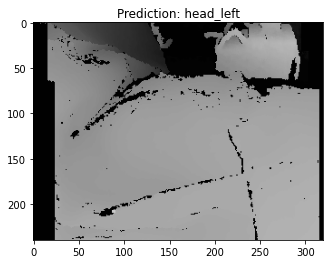

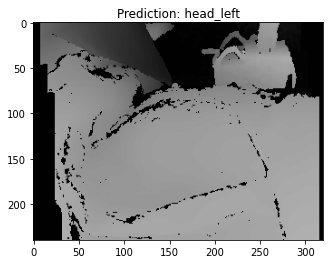

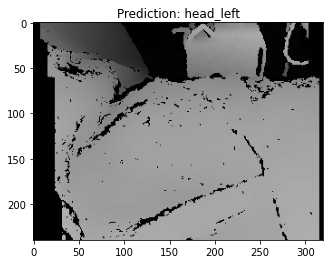

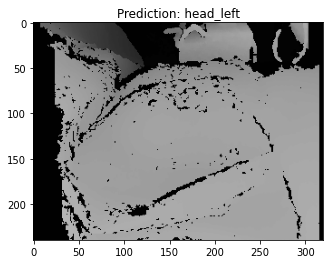

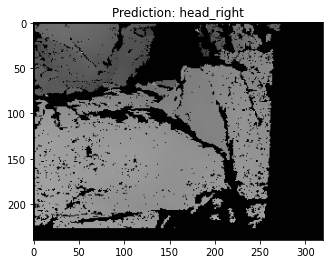

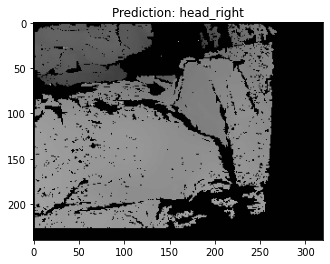

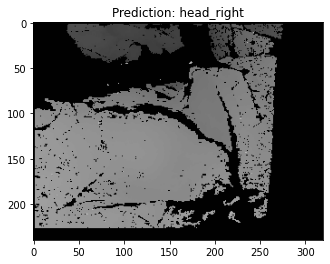

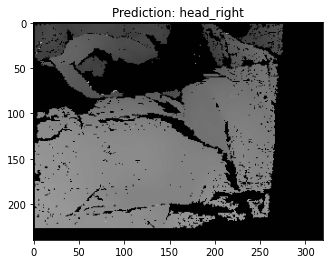

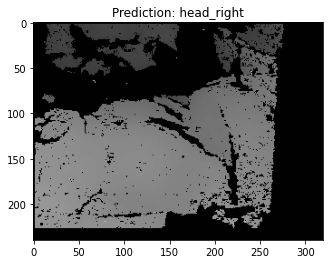

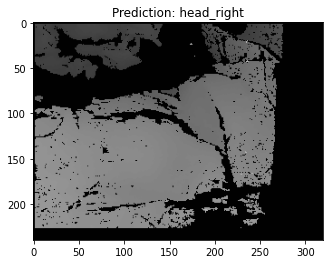

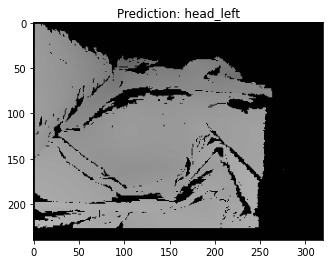

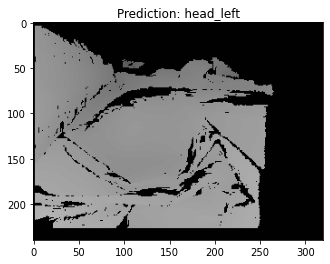

In [35]:
classify(model, get_transform(), './dataset/test_prediction', classes)

##**Getting fancier**

In [87]:
def classify_fancy(model, image_transforms, images_path, classes):
  model = model.eval()
  offset = 30
  for image in os.listdir(images_path):
    img = cv2.imread(os.path.join(images_path, image), 1)
    dimension = img.shape
    height = dimension[1] 
    width = dimension[0] 

    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    img = img.float()
    img = image_transforms(img)
    img = img.permute(0,3,2,1)

    output = model(img)
    _, prediction = torch.max(output.data, 1)

    predicted_class = classes[prediction.item()]

    img = img.permute(0,3,2,1)
    img = img.numpy()

    if (predicted_class == 'head_left'):
      x = width / 2 + offset
      y = height / 3 + offset - 10

      plt.arrow(x, y, -75, 0, width = 10)
      plt.imshow((img[0] * 255).astype(np.uint8), cmap='gray')
      plt.title(f'Prediction: {predicted_class}')
      plt.show()

    else:
      x = width / 2 + offset
      y = height / 3 + offset - 10

      plt.arrow(x, y, 75, 0, width = 10)
      plt.imshow((img[0] * 255).astype(np.uint8), cmap='gray')
      plt.title(f'Prediction: {predicted_class}')
      plt.show()

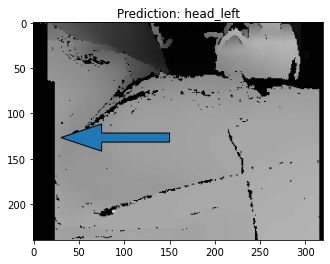

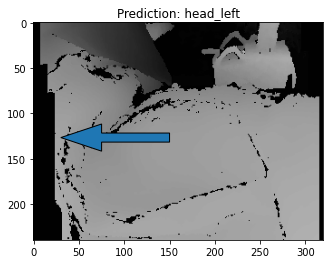

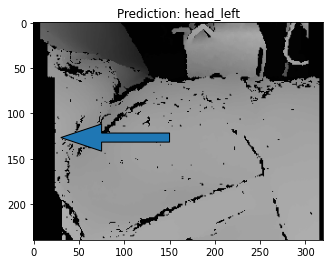

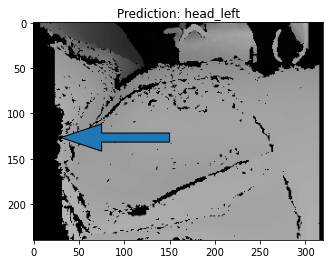

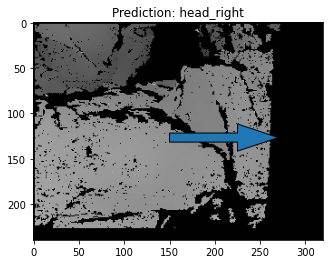

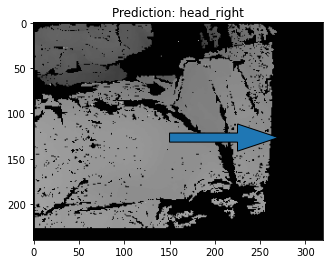

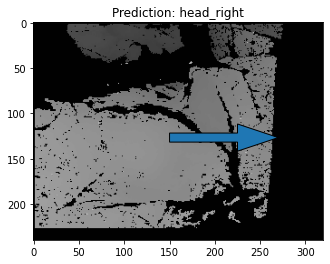

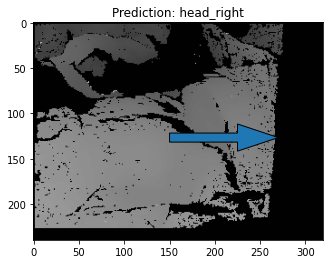

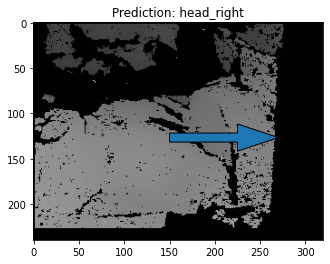

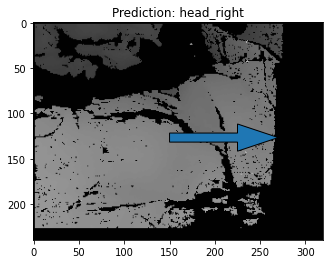

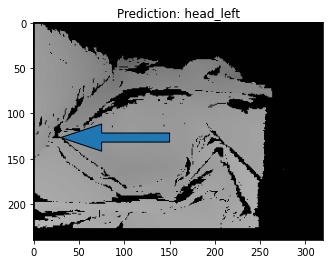

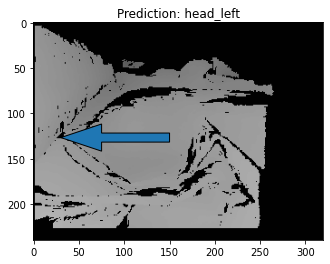

In [88]:
classify_fancy(model, get_transform(), './dataset/test_prediction', classes)